In [1]:
import os
from typing import Union
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
from astropy.visualization.wcsaxes import add_scalebar
import astropy.units as u
from astropy.table import Table
from astropy.stats import SigmaClip
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, ApertureStats

### Simple cutout

In [2]:
def add_good_scalebar(ax, wcs, color='white', fraction=0.25, corner='bottom right', pad=0.1):
    width = abs(proj_plane_pixel_scales(wcs)[0]*wcs.pixel_shape[0])*u.degree
    good_values = [0.5*u.arcsec, 1*u.arcsec, 2*u.arcsec, 3*u.arcsec, 5*u.arcsec, 10*u.arcsec, 20*u.arcsec,
                0.5*u.arcmin, 1*u.arcmin, 2*u.arcmin, 3*u.arcmin, 5*u.arcmin, 10*u.arcmin, 20*u.arcmin,
                0.5*u.degree, 1*u.degree, 2*u.degree, 5*u.degree, 10*u.degree]
    dist = np.array([(fraction*width-val).value for val in good_values])
    dist[dist<0] = np.inf
    size = good_values[np.argmin(dist)]
    add_scalebar(ax, size, label=f"{size:latex}", color=color, fontproperties=FontProperties(size='x-large'), label_top=True, pad=pad, corner=corner)

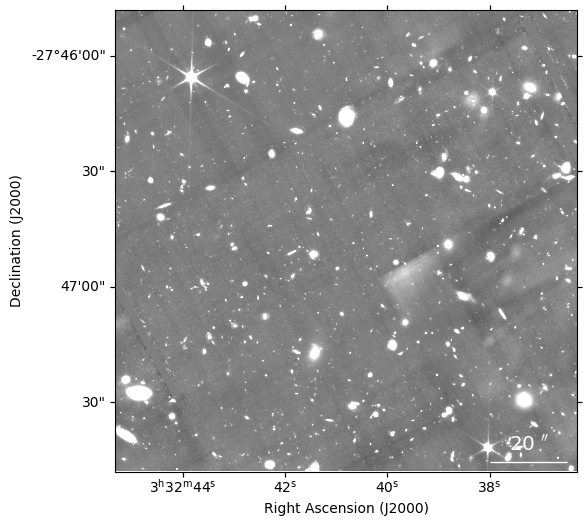

In [3]:
# hdu = fits.open(f"/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f200w-clear_drc_sci.fits", memmap=True)[0]
# hdu = fits.open("/home/aurelien/DAWN/DJA_SE++/image/COSMOS/primer-cosmos-grizli-v7.0-f200w-clear_drc_sci.fits", memmap=True)[0]
# hdu = fits.open("/home/aurelien/DAWN/DJA_SE++/image/CEERS/ceers-full-grizli-v7.2-f200w-clear_drc_sci.fits", memmap=True)[0]
hdu = fits.open(f"/FlashStorage/tmp/gds-grizli-v7.2-f090w-clear_drc_sci.fits", memmap=True)[0]
wcs = WCS(hdu.header)

# center = SkyCoord('53.166338 -27.821555', frame='icrs', unit='deg') # JADES-GS-z12.0
center = SkyCoord('53.17 -27.78', frame='icrs', unit='deg') # GDS
# center = SkyCoord('10h00m35s 02d20m00s', frame='icrs') # COSMOS
# center = SkyCoord('14h19m45s 52d54m00s', frame='icrs') # CEERS
size=u.Quantity((2.0,2.0), u.arcmin)

cutout = Cutout2D(hdu.data, 
                  position=center, size=size, 
                  wcs=wcs,
                  mode='partial', fill_value=0.0)

fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':cutout.wcs})
norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
# norm = ImageNormalize(cutout.data, interval=MinMaxInterval(), stretch=LogStretch())
ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
add_good_scalebar(ax, cutout.wcs)
plt.show()

### Batch cutouts

In [4]:
def save_cutouts(generic_filename   : str, 
                 center             : Union[tuple[str],SkyCoord] , 
                 size               : Union[int,u.Quantity],
                 save_folder        : str = None, 
                 plot               : bool = False,
                 plot_str           : str = None,
                 verbose            : bool = False) -> None :
    """
    Create cutouts for all selected images, 
    centered on the same point and with the same size.

    * `generic_filename` (`str` with wildcard) : 
        Generic filename for the images to process.
        Can use wildcards (*,?) readable by `glob.glob`.
    * `center` (`tuple[str]` or `SkyCoord`) :
        Center of the cutouts.
        Can be in pixel units, or an `astropy.coordinates.SkyCoord` object (e.g. RA-DEC).
    * `size` (`int` or `Quantity`):
        Size of the cutouts.
        Can be in pixel units, or an `astropy.units.Quantity` object (e.g. angular size).
        WARNING : If pixel scale is different between images, giving a size in pixel units will result in non-aligned images.
    * `save_folder` (`str`, optional):
        Folder to save the cutouts in.
        By default, the images will be saved in a `cutout` sub_folder of the initial folder.
    * `plot` (`bool`, optional):
        Plots the cutouts with MinMax and Log stretching.
    * `plot_str` (`str`, optional):
        String to be found in image name to plot it. 
        Only active if `plot=True`. By default, all images are plotted.
    * `verbose` (`bool`, optional)
    """
    image_list = glob.glob(generic_filename)
    n = len(image_list)
    if verbose: print(f"Number of images found : {n}")
    if verbose: print(f"Images found :")
    if verbose: 
        for img in image_list: print(img)
    if plot: fig, j = plt.figure(figsize=(12,12)), 1
    for i,img in enumerate(image_list):
        print(f"Image {i+1} / {n}")
        # Load image
        hdu = fits.open(img, memmap=True)[0]
        wcs = WCS(hdu.header)
        # Cutout
        cutout = Cutout2D(hdu.data, 
                    position=center, size=size, 
                    wcs=wcs,
                    mode='partial', fill_value=0.0)
        # Save cutout
        hdu.data = cutout.data
        hdu.header.update(cutout.wcs.to_header())
        parsed_name = img.split("/")
        folder = "/".join(parsed_name[:-1])
        init_name = parsed_name[-1]
        name = f"{'.'.join(init_name.split('.')[:-1])}_cutout.fits"
        if save_folder is None: save_folder = f"{folder}/cutout"
        if not os.path.exists(save_folder): os.mkdir(save_folder) 
        hdu.writeto(f"{save_folder}/{name}", overwrite=True)
        # Plot cutout
        if plot:
            if plot_str is None or plot_str in init_name:
                ax = fig.add_subplot(max(1,int(np.sqrt(n))),max(1,int(np.sqrt(n))),j, projection=cutout.wcs)
                norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
                ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
                ax.set_title(init_name, size='xx-small')
                ax.set_axis_off()
                j+=1
    if plot: fig.tight_layout()
    if plot: plt.show()

Number of images found : 24
Images found :
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f090w-clear_drc_sci.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f090w-clear_drc_wht.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f115w-clear_drc_sci.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f115w-clear_drc_wht.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f150w-clear_drc_sci.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f150w-clear_drc_wht.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f182m-clear_drc_sci.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f182m-clear_drc_wht.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f200w-clear_drc_sci.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f200w-clear_drc_wht.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f210m-clear_drc_sci.fits
/home/aurelien/DAWN/DJA_SE++/image/GDS/gds-grizli-v7.0-f210m-clear_drc_wht.fi

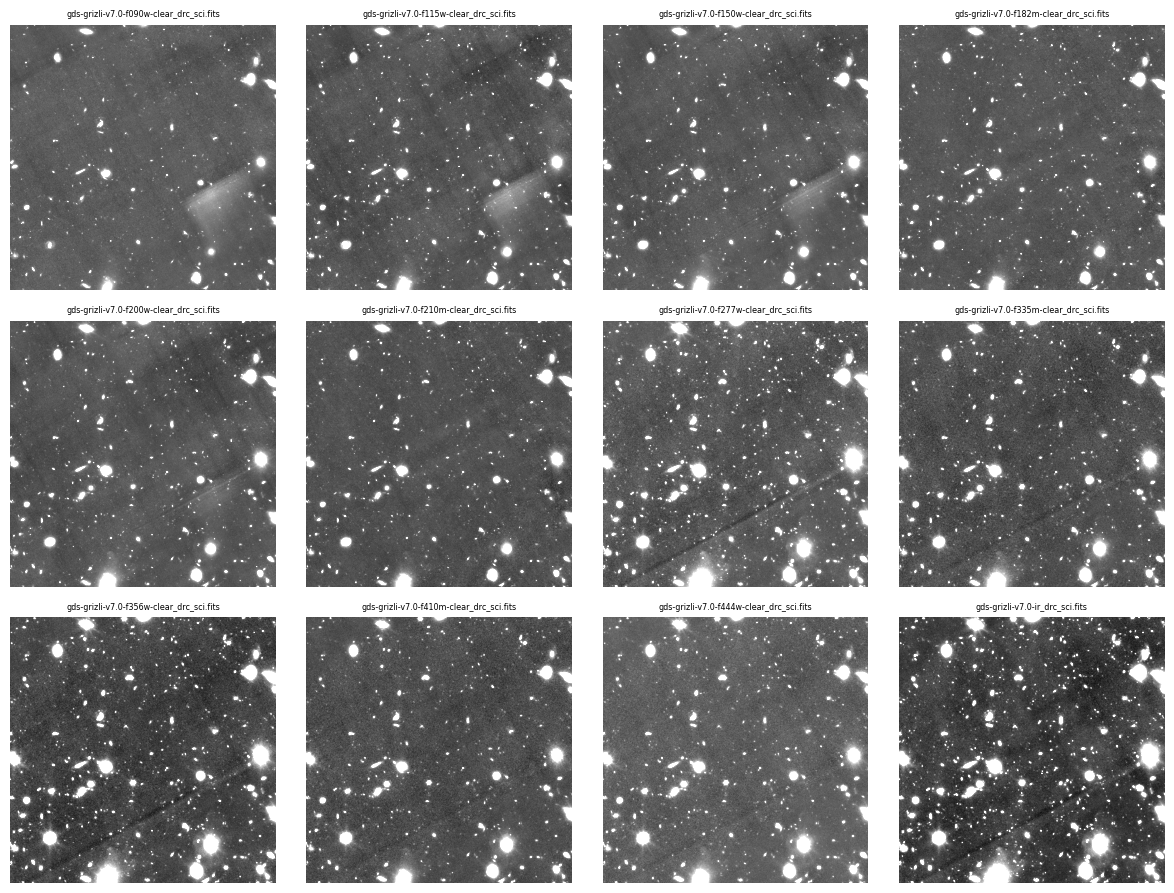

In [11]:
# center = SkyCoord('53.166338 -27.821555', frame='icrs', unit='deg') # JADES-GS-z12.0
center = SkyCoord('53.17 -27.78', frame='icrs', unit='deg') # GDS
# center = SkyCoord('10h00m35s 02d20m00s', frame='icrs') # COSMOS
# center = SkyCoord('14h19m39s 52d54m00s', frame='icrs') # CEERS
size=u.Quantity((2.0,2.0), u.arcmin)

save_cutouts("/FlashStorage/tmp/*.fits", center, size, 
            save_folder="/home/ec2-user/DAWN/DJA-SEpp/image/GDS",
            plot=True, plot_str="sci", verbose=True)

### Fun photometry

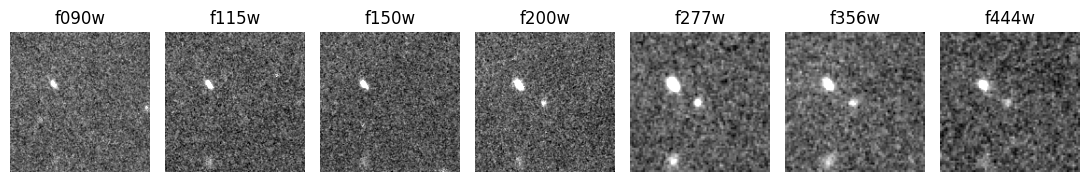

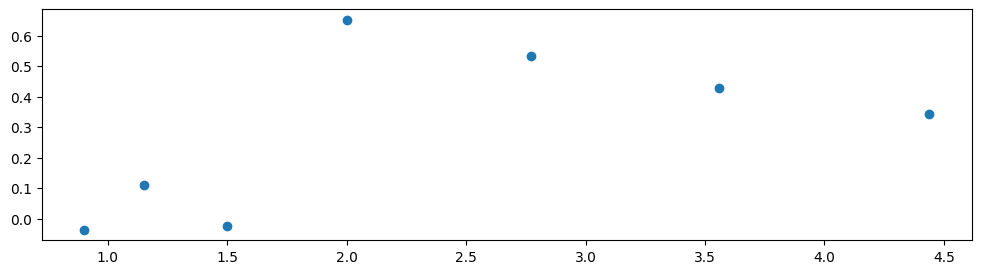

In [17]:
# Same cutout in all bands

# center = SkyCoord('53.166338 -27.821555', frame='icrs', unit='deg') # JADES-GS-z12.0
center = SkyCoord('53.149880 -27.776500', frame='icrs', unit='deg') # JADES-GS-z13.0)
size = u.Quantity((3.0,3.0), u.arcsec)

image_list = glob.glob("/home/aurelien/DAWN/DJA_SE++/image/GDS/*f*_sci.fits")
photometry = {"Wavelength" : [], "Flux" : []}
fig, i = plt.figure(figsize=(11,4)), 1
for img in image_list:
    # Load image
    hdu = fits.open(img, memmap=True)[0]
    wcs = WCS(hdu.header)
    filter = img.split("/")[-1].split("_")[0].split("-")[3]
    # Cutout
    cutout = Cutout2D(hdu.data, 
                position=center, size=size, 
                wcs=wcs)
    # Plot cutout
    ax = fig.add_subplot(1,7,i, projection=cutout.wcs)
    norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
    ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
    ax.set_title(filter)
    ax.set_axis_off()
    i += 1
    # Aperture photometry
    photometry["Wavelength"].append(float(filter[1:4])/100)
    aperture = SkyCircularAperture(center, r=0.15*u.arcsec)
    annulus_aperture = SkyCircularAnnulus(center, r_in=0.3*u.arcsec, r_out=0.45*u.arcsec)
    sigclip = SigmaClip(sigma=3.0, maxiters=10)
    bkg_stats = ApertureStats(cutout.data, annulus_aperture, sigma_clip=sigclip, wcs=cutout.wcs)
    aper_stats_bkgsub = ApertureStats(cutout.data, aperture, local_bkg=bkg_stats.median, wcs=cutout.wcs)
    photometry["Flux"].append(aper_stats_bkgsub.sum)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.scatter(photometry["Wavelength"], photometry["Flux"])
plt.show()